<a href="https://colab.research.google.com/github/u5638928/u5638928-DataScience-GenAI-Submissions/blob/main/5_01_Random_Forest_and_GBDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://drive.google.com/uc?export=view&id=1xqQczl0FG-qtNA2_WQYuWePW9oU8irqJ)

# 5.01 Random Forest and Gradient Boosting Decision Trees
In this notebook we will extend the solution to last week's notebook by also looking at Random Forest and two GBDT implementations (the native scikit-learn implementation and also _eXtreme Gradient Boosting Decision Trees_ - _XGBDT_). The latter is basically a slighly more sophisticated implementation.

We start with a prepared dataset available on my.wbs:




In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credit_data_final.csv to credit_data_final.csv


In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('credit_data_final.csv')

y_value = df['class'] # set the y
y_values = np.ravel(y_value) # change to an array (list)

x_values = df.drop('class', axis=1) # drop the y from the dataframe

# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x_values, y_value, test_size = 0.2, random_state=4567, stratify=y_value)

# print the shapes to check everything is OK
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 28)
(200, 28)
(800,)
(200,)


## Modeling and Evaluation
We will set up algorithms for logistic regression (the previous winner) and then our new algorithms.

Just to look at the impact of hyperparameter optimisation, we will set them up initially with default hyperparameters and compare their performance (on the training data):

In [ ]:
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GBDT
from xgboost import XGBClassifier as XGB
from sklearn.metrics import precision_recall_fscore_support

LogR_algo = LogR()
LogR_model = LogR_algo.fit(X_train, Y_train)

RF_algo = RF()
RF_model = RF_algo.fit(X_train, Y_train)

GBDT_algo = GBDT()
GBDT_model = GBDT_algo.fit(X_train, Y_train)

XGB_algo = XGB()
XGB_model = XGB_algo.fit(X_train, Y_train)

models = [LogR_model, RF_model, GBDT_model, XGB_model]
names = ['Logistic Regression', 'Random Forest', 'GBDT', 'XGBDT']

for i in range(4):
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


Model: Logistic Regression
Macro Precision: 0.695493494128848
Macro Recall: 0.6145833333333334
Macro F1-score: 0.6216980598450139


Model: Random Forest
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0


Model: GBDT
Macro Precision: 0.8988486842105263
Macro Recall: 0.8464285714285714
Macro F1-score: 0.8668188736681888


Model: XGBDT
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0




Random Forest and XGBDT score perfectly - but is it overfitting? Let's hyperparameter tune them and see the scores again (on training data):

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# we get a load of warnings running the code so will supress them
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function for re-usability
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=2015,
                          scoring='precision_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)

  return clf.best_params_

# Logistic Regression
LogR_tuned_parameters = {
    'solver': ['liblinear'], # only this one as it does both L1 and L2
    # C is the equivalent of alpha in L1/L2 regression - how much regularisation
    'C': uniform(loc=0.1, scale=19.9),  # Draw from a uniform distribution between 0.1 and 20
    'penalty': ['l1', 'l2', 'elasticnet', None] # elasticnet is a mix of L1 and L2
}

LogR_best_params = random_search(LogR_algo, LogR_tuned_parameters, X_train, Y_train)


# Random Forest
RF_tuned_parameters = {
    'n_estimators': randint(50, 500), # Draw from a uniform distribution between 50 and 500
    'max_depth': randint(2, 7),  # Draw from a uniform distribution between 2 and 7
    'min_samples_split': randint(2, 7),  # Draw from a uniform distribution between 2 and 7
    'max_features': ['sqrt', 'log2', None]
}

RF_best_params = random_search(RF_algo, RF_tuned_parameters, X_train, Y_train)


# GBDT
GBDT_tuned_parameters = {
    'n_estimators': randint(25, 250), # Draw from a uniform distribution between 50 and 500
    'learning_rate': uniform(loc=0.01, scale=4.99),  # Draw from a uniform distribution between 0.01 and 5
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': randint(2, 7)  # Draw from a uniform distribution between 2 and 7
}

GBDT_best_params = random_search(GBDT_algo, GBDT_tuned_parameters, X_train, Y_train)


# XGBDT
XGB_tuned_parameters = {
    'n_estimators': randint(25, 250), # Draw from a uniform distribution between 50 and 500
    # eta is learning rate
    'eta': uniform(loc=0.01, scale=4.99),  # Draw from a uniform distribution between 0.01 and 5
    # objective is the same as criterion
    'objective': ['binary:logistic', 'binary:hinge'],
    'max_depth': randint(2, 7)  # Draw from a uniform distribution between 2 and 7
}

XGB_best_params = random_search(XGB_algo, XGB_tuned_parameters, X_train, Y_train)


# Train the models
LogR_algo = LogR(**LogR_best_params)
LogR_model = LogR_algo.fit(X_train, Y_train)

RF_algo = RF(**RF_best_params)
RF_model = RF_algo.fit(X_train, Y_train)

GBDT_algo = GBDT(**GBDT_best_params)
GBDT_model = GBDT_algo.fit(X_train, Y_train)

XGB_algo = XGB(**XGB_best_params)
XGB_model = XGB_algo.fit(X_train, Y_train)


# score the models
models = [LogR_model, RF_model, GBDT_model, XGB_model] # redo this or it uses the old models

for i in range(len(models)): # for every model in the models list
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6981523631008166
Macro Recall: 0.6211309523809524
Macro F1-score: 0.629761289933129


Model: Random Forest
Macro Precision: 0.8544303797468354
Macro Recall: 0.5208333333333334
Macro F1-score: 0.4548148148148148


Model: GBDT
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0


Model: XGBDT
Macro Precision: 1.0
Macro Recall: 1.0
Macro F1-score: 1.0




Our scores are ... a bit different from last time. In fact GBDT went up to perfect. However, the real test is the score on our test data:

In [ ]:
for i in range(4):
  print(f"Model: {names[i]}")

  # predict based on TEST data
  predict = models[i].predict(X_test)

  # Calculate precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Logistic Regression
Macro Precision: 0.6376488095238095
Macro Recall: 0.5880952380952381
Macro F1-score: 0.590626764539808


Model: Random Forest
Macro Precision: 0.8553299492385786
Macro Recall: 0.525
Macro F1-score: 0.4630493146813622


Model: GBDT
Macro Precision: 0.7636378709998342
Macro Recall: 0.6892857142857143
Macro F1-score: 0.7073934197543466


Model: XGBDT
Macro Precision: 0.6741164241164241
Macro Recall: 0.6595238095238095
Macro F1-score: 0.6651785714285714




Similar to last time, our best scorer for our prefered metric (_macro precision_) scores worse for everything else. We can make a good case to look further at both Random Forest and GBDT. So let's do that:

Random Forest Confusion Matrix


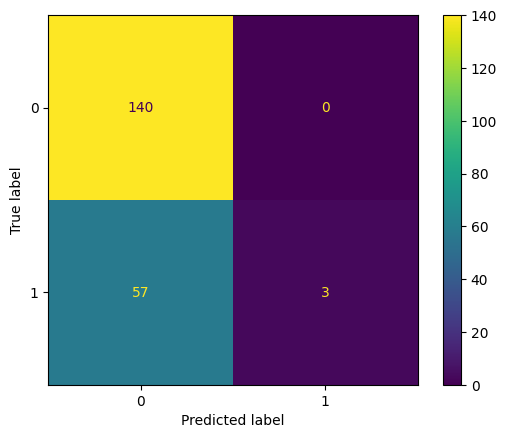

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay as CM

# Random Forest
print("Random Forest Confusion Matrix")
predict = RF_model.predict(X_test)
CM.from_predictions(Y_test, predict)

GBDT Confusion Matrix


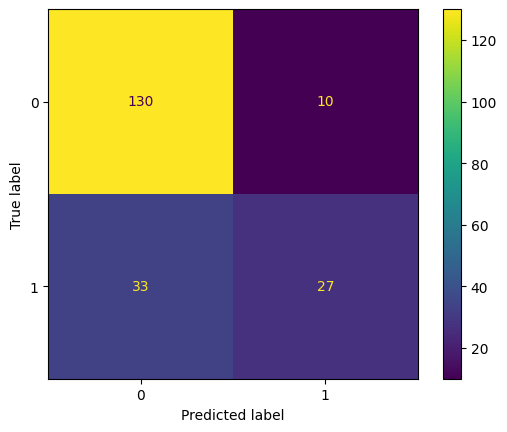

In [ ]:
# GBDT
print("GBDT Confusion Matrix")
predict = GBDT_model.predict(X_test)
print(CM.from_predictions(Y_test, predict))

We can see they are wrong in different ways. Because we care most about minimising cases we predict "0" (good to loan to) and in fact they are a "1" (bad to loan to), GBDT should be best. Random Forest misclassifies 56 cases in this way (more than Logistic Regression), while GBDT only 31. Also, random forest only predicts "1" a total of 4 times. GBDT is much more balanced in the predictions it makes for each class.

So GBDT is the winner.


***Observation***:
Initially, both Random Forest and XGBDT models achieved perfect scores on the training data, indicating significant overfitting. After applying hyperparameter tuning, the training performance of Random Forest decreased, suggesting that tuning helped mitigate some of the overfitting for that model. GBDT and XGBDT, however, continued to show perfect training scores. The true evaluation on the test data revealed that while Random Forest achieved a high macro precision (0.85), its macro recall was notably low (0.52). GBDT demonstrated a better balance of macro precision (0.76) and macro recall (0.68), resulting in a higher macro F1-score. Crucially, when analyzing the confusion matrices, GBDT was identified as the preferred model because it minimized the critical misclassification of 'good' loan applicants (class 0) as 'bad' (class 1) compared to Random Forest (31 vs 56 such errors). GBDT also provided more balanced predictions across classes, making it the most suitable model for this specific business problem.